In [1]:
from new_thesis_library import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 100

%matplotlib inline

# Moex thetas

In [2]:
moex_thetas = pd.read_csv(path + 'Data/New_data/moex_dynamic.csv',
                          sep = ';')

moex_thetas['tradedate'] = pd.to_datetime(moex_thetas['tradedate'], format='%d.%m.%Y')
moex_thetas[['B1', 'B2', 'B3', 'T1']] = moex_thetas[['B1', 'B2', 'B3', 'T1']].apply(lambda x: x.str.replace(',','.'))
moex_thetas[['B1', 'B2', 'B3', 'T1']] = moex_thetas[['B1', 'B2', 'B3', 'T1']].astype('float64')
moex_thetas[['B1', 'B2', 'B3']] = moex_thetas[['B1', 'B2', 'B3']]/10000
moex_thetas = moex_thetas[['tradedate', 'T1', 'B1', 'B2', 'B3']]
moex_thetas.set_index('tradedate', inplace = True)

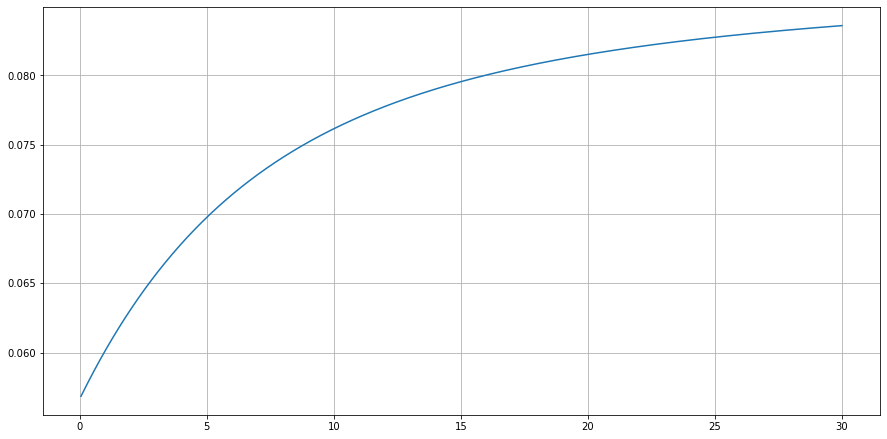

In [3]:
m = np.linspace(0, 30, 600)
plt.figure(figsize = (15,7.5))
plt.grid()
plt.plot(m, ns(m, moex_thetas[0:1].values[0]), label = 'NS curve');

In [4]:
moex_thetas_stats = moex_thetas.describe()
moex_thetas_stats

,T1,B1,B2,B3
count,1643.000000,1643.000000,1643.000000,1643.000000
mean,4.871800,0.087704,-0.011902,0.003621
std,4.515339,0.015014,0.023744,0.038101
min,0.300073,0.055520,-0.063911,-0.073377
25%,1.538723,0.079948,-0.025936,-0.020286
50%,3.381781,0.085636,-0.014949,0.001554
75%,6.234200,0.092933,0.000730,0.022876
max,17.525151,0.130801,0.056864,0.119194


In [5]:
[(0, 30), 
(moex_thetas_stats['B1']['min'] - 3 * moex_thetas_stats['B1']['std'], moex_thetas_stats['B1']['max'] + 3 * moex_thetas_stats['B1']['std']), 
(moex_thetas_stats['B2']['min'] - 3 * moex_thetas_stats['B2']['std'], moex_thetas_stats['B2']['max'] + 3 * moex_thetas_stats['B2']['std']), 
(moex_thetas_stats['B3']['min'] - 3 * moex_thetas_stats['B3']['std'], moex_thetas_stats['B3']['max'] + 3 * moex_thetas_stats['B3']['std'])]

[(0, 30),
 (0.010477198590003643, 0.17584359090999638),
 (-0.13514205198012594, 0.12809433098012593),
 (-0.1876796706900865, 0.2334965658900865)]

In [6]:
data_dict = {}
data_dict['category'] = [r'$\beta_2$', r'$\beta_1$', r'$\beta_0$']
data_dict['lower'] = [moex_thetas_stats['B3']['min'] - 3 * moex_thetas_stats['B3']['std'],
                      moex_thetas_stats['B2']['min'] - 3 * moex_thetas_stats['B2']['std'],
                      moex_thetas_stats['B1']['min'] - 3 * moex_thetas_stats['B1']['std']]
data_dict['upper'] = [moex_thetas_stats['B3']['max'] + 3 * moex_thetas_stats['B3']['std'], 
                      moex_thetas_stats['B2']['max'] + 3 * moex_thetas_stats['B2']['std'], 
                      moex_thetas_stats['B1']['max'] + 3 * moex_thetas_stats['B1']['std']]
dataset = pd.DataFrame(data_dict)

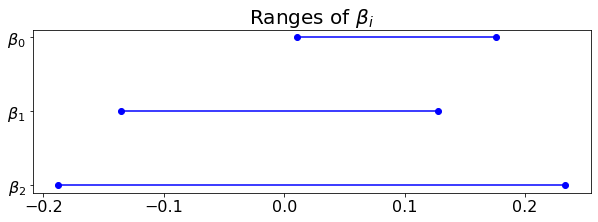

In [7]:
figure, axes = plt.subplots(nrows=1, ncols=1,figsize=(10, 3))

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    axes.plot((lower,upper),(y,y),'ro-',color='b')
plt.yticks(range(len(dataset)),list(dataset['category']), fontsize = 16)
axes.set_title(r'Ranges of $\beta_i$', fontsize = 20)
axes.tick_params(axis='x', which='major', labelsize=16)
axes.tick_params(axis='y', which='major', labelsize=16)
figure.savefig('Pictures/Ranges_of_betas.png');

# Generating random values

We will be generating random values in the borders of max/min +- 3 std for betas, [0, 30] for tau.

In [8]:
np.random.seed(1)

for i in range(16):
    random_thetas = np.zeros([len(dates), 5])
    for j in range(len(dates)):
        random_thetas[j] = np.array([int(i + 1), 
                                     np.random.uniform(0, 30), 
                                     np.random.uniform(moex_thetas_stats['B1']['min'] - 3 * moex_thetas_stats['B1']['std'], moex_thetas_stats['B1']['max'] + 3 * moex_thetas_stats['B1']['std']), 
                                     np.random.uniform(moex_thetas_stats['B2']['min'] - 3 * moex_thetas_stats['B2']['std'], moex_thetas_stats['B2']['max'] + 3 * moex_thetas_stats['B2']['std']), 
                                     np.random.uniform(moex_thetas_stats['B3']['min'] - 3 * moex_thetas_stats['B3']['std'], moex_thetas_stats['B3']['max'] + 3 * moex_thetas_stats['B3']['std'])])
    random_thetas = pd.DataFrame(random_thetas, columns = ['Value', 'tau', 'beta0', 'beta1', 'beta2'], index = dates)
    random_thetas.to_csv(path + 'Data/New_data/Random_thetas/rand_' + str(i + 1) + '.csv')

# Diebold, Li starting values

### IRR calculation

In [4]:
def npv(irr, cfs, yrs):  
    return np.sum(cfs / (1. + irr) ** yrs)

In [5]:
from scipy.optimize import fsolve

def irr(cfs, yrs, x0):
    return np.asscalar(fsolve(npv, x0=x0, args=(cfs, yrs)))

In [6]:
def maturities_irrs(date_number):
    irrs = []
    maturities = []
    payments_on_date = bonds_payments[bonds_payments['Дата фактической выплаты'] >= dates[date_number]]
    
    for ticker in bond_isins:
    
        payments = payments_on_date[payments_on_date['ISIN'] == ticker]['Сумма купона, RUB'] + payments_on_date[payments_on_date['ISIN'] == ticker]['Погашение номинала, RUB'].values
        payments_dates = (payments_on_date[payments_on_date['ISIN'] == ticker]['Дата фактической выплаты'] - dates[date_number]).apply(lambda x: x.days)/365
        
        investment = bonds_prices.iloc[date_number][ticker]
        payments = np.insert(np.array(payments), 0, -investment)
        payments_dates = np.insert(np.array(payments_dates), 0, 0)
        
        if np.isnan(payments[0]) == True:
            irrs.append(np.nan)
            maturities.append(np.nan)
        else:
            bond_irr = irr(cfs=payments, yrs=payments_dates, x0=0.10)
            irrs.append(bond_irr)
            maturities.append(payments_dates[-1])
            
        
    return (np.array([maturities]), np.array([irrs]))   

In [8]:
irr_matrix = pd.DataFrame(np.zeros(bonds_prices.shape), index = dates, columns = bond_isins)
maturity_matrix = pd.DataFrame(np.zeros(bonds_prices.shape), index = dates, columns = bond_isins)

In [6]:
%%time

for i in range(len(dates)):
    maturity_matrix[dates[i]:dates[i]], irr_matrix[dates[i]:dates[i]] = maturities_irrs(i)    

CPU times: user 3min 10s, sys: 918 ms, total: 3min 10s
Wall time: 3min 14s


In [7]:
%%bash
say finished

In [8]:
maturity_matrix.to_csv(path + 'Data/New_data/bonds_maturities.csv')
irr_matrix.to_csv(path + 'Data/New_data/bonds_irrs.csv')

In [9]:
maturity_matrix = pd.read_csv(path + 'Data/New_data/bonds_maturities.csv', index_col='TRADEDATE', parse_dates=True)
irr_matrix = pd.read_csv(path + 'Data/New_data/bonds_irrs.csv', index_col='TRADEDATE', parse_dates=True)

## BOOTSRAP

1. Сортируем бонды по их длине
2. Первую ставку взять из IRR наиболее короткого бонда
3. Далее решать каждый бонд при условии более коротких ставок.

In [10]:
from scipy.optimize import fsolve

In [11]:
def discount_by_rates(df, rates):
    df['Discounted'] = (df['Сумма купона, RUB'] + df['Погашение номинала, RUB']) * np.exp(-rates * df['Дата фактической выплаты'])

In [12]:
def generate_solve_for_rate(unknown, known, price):
    def solve_for_rate(rate):
        nonlocal unknown, known, price
        unknown['rates'] = np.ones(unknown.shape[0]) * rate
        discount_by_rates(unknown, unknown['rates'])
        return known + unknown.Discounted.sum() - price    
    
    return solve_for_rate

In [13]:
def bootsrap_rates_on_day(day_number):
    
    sorted_bonds = maturity_matrix.iloc[day_number].sort_values()
    sorted_bonds.dropna(inplace=True)
#    print(sorted_bonds)
            
    bootstraped_rates = {}
    bootstraped_rates[sorted_bonds.iloc[0]] = irr_matrix.iloc[day_number][sorted_bonds.index[0]]
#    print(bootstraped_rates, type(list(bootstraped_rates.keys())[0]))

    for i in range(1, sorted_bonds.shape[0]):
        
        payments_after_date = bonds_payments[(bonds_payments['ISIN'] == sorted_bonds.index[i]) & 
                                         (bonds_payments['Дата фактической выплаты'] > 
                                          dates[day_number])][['Сумма купона, RUB', 
                                                               'Погашение номинала, RUB', 
                                                               'Дата фактической выплаты']]

        calc_df = pd.concat([(payments_after_date['Дата фактической выплаты'] - dates[day_number]).apply(lambda x: x.days)/365, 
                         payments_after_date['Сумма купона, RUB'], payments_after_date['Погашение номинала, RUB']], 
                        axis = 1)
        calc_df['rates'] = np.zeros(calc_df.shape[0])

        #print(i)
        #print(calc_df)
        #
        #print(bootstraped_rates)


        
        known_rates_df = calc_df[calc_df['Дата фактической выплаты'] <= list(bootstraped_rates.keys())[i - 1]]       
        
        for j in range(len(bootstraped_rates)):
            
            #нужно заполнить столбец известными ставками
            mask = known_rates_df['Дата фактической выплаты'] < list(bootstraped_rates)[len(bootstraped_rates) - 1 - j]
            known_rates_df['rates'][mask] = bootstraped_rates[list(bootstraped_rates)[len(bootstraped_rates) - 1 - j]]
            #заполнили
        
        # дисконтируем известные платежи
        discount_by_rates(known_rates_df, known_rates_df['rates'])
        #считаем их сумму
#        print(known_rates_df)
        known = known_rates_df['Discounted'].sum()
#        print('Known:', known)
        
        
        #считываем цену
        price = bonds_prices.iloc[day_number][sorted_bonds.index[i]]
#        print('Price', price)
            
        unknown_rates_df = calc_df[calc_df['Дата фактической выплаты'] > list(bootstraped_rates.keys())[i - 1]]
#        print(unknown_rates_df)
        
        #генеририуем функцию для поиска неизвестной ставки 
        solve_for_rate_function = generate_solve_for_rate(unknown_rates_df, known, price)
        new_rate = fsolve(solve_for_rate_function, 0.1)[0]
#        print(new_rate)
                
        bootstraped_rates[sorted_bonds.iloc[i]] = new_rate

     
    return bootstraped_rates

In [14]:
%%time

all_bootstraped_rates = []

for i in range(len(dates)):
#    print('Day ' + str(i))
    all_bootstraped_rates.append(bootsrap_rates_on_day(i))

KeyboardInterrupt: 

In [22]:
%%bash
say finished

In [23]:
for i in range(len(dates)):
    bt_rates_df = pd.DataFrame.from_dict(all_bootstraped_rates[i], orient='index', columns = ['rate'])
    bt_rates_df.reset_index(level = 0, inplace = True)
    bt_rates_df.columns = ['maturity', 'rates']
    bt_rates_df.to_csv(path + 'Data/New_data/Bootstraped_rates/bt_rates_' + str(dates[i].date()) + '.csv')

In [10]:
bootstraped_rates_list = []

for i in range(len(dates)):
    bootstraped_rates_list.append(pd.read_csv(path + 'Data/New_data/Bootstraped_rates/bt_rates_' + str(dates[i].date()) + '.csv', index_col=0))

#  Problematic dates

In [ ]:
dates[107], dates[150], dates[285], dates[314], dates[331], dates[1542]

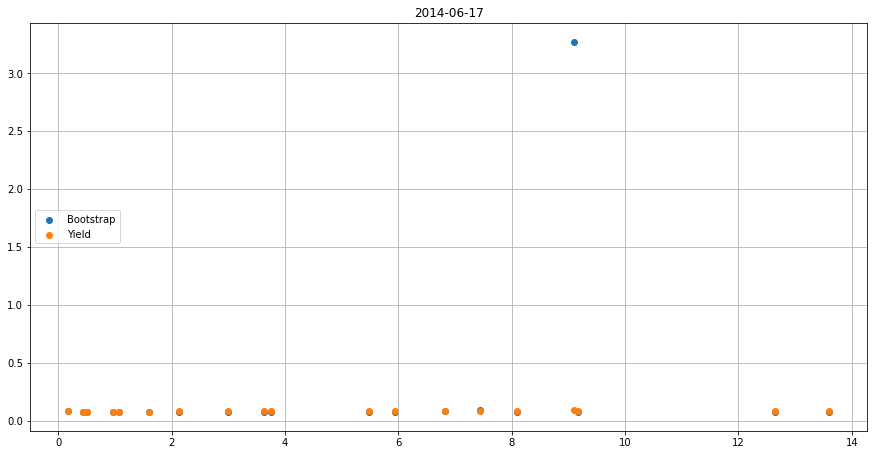

In [51]:
j = 150

plt.figure(figsize = (15, 7.5))
plt.title(dates[j].date())
plt.scatter(bootstraped_rates_list[j].maturity, bootstraped_rates_list[j].rates, label = 'Bootstrap')
plt.scatter(maturity_matrix[dates[j]:dates[j]].values, irr_matrix[dates[j]:dates[j]].values, label = 'Yield')
plt.legend(loc = 6)
#plt.ylim(0, 0.2)
plt.grid();

In [10]:
bootstrap_yield_MAE = np.zeros(len(dates))

for i in range(len(dates)):
    concat_df = pd.concat([maturity_matrix[dates[i]:dates[i]].dropna(axis = 1), irr_matrix[dates[i]:dates[i]].dropna(axis = 1)])
    sorted_df = concat_df.T
    sorted_df.columns = ['Maturity', 'Yield']
    yields = sorted_df.sort_values(['Maturity']).Yield.values
    bootstrap_yield_MAE[i] = np.mean(np.abs((bootstraped_rates_list[i].rates.values - yields)))

(0.0, 0.03)

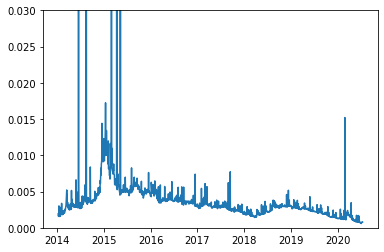

In [11]:
plt.plot(dates, bootstrap_yield_MAE)
plt.ylim(0, 0.03)

In [105]:
problematic_dates = dates[bootstrap_yield_MAE > 0.018]
problematic_dates

DatetimeIndex(['2014-06-17', '2014-08-15', '2015-03-02', '2015-04-13',
               '2015-05-08'],
              dtype='datetime64[ns]', name='TRADEDATE', freq=None)

In [109]:
dates[107], dates[150], dates[285], dates[314], dates[331], dates[1542]

(Timestamp('2014-06-17 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2015-03-02 00:00:00'),
 Timestamp('2015-04-13 00:00:00'),
 Timestamp('2015-05-08 00:00:00'),
 Timestamp('2020-02-26 00:00:00'))

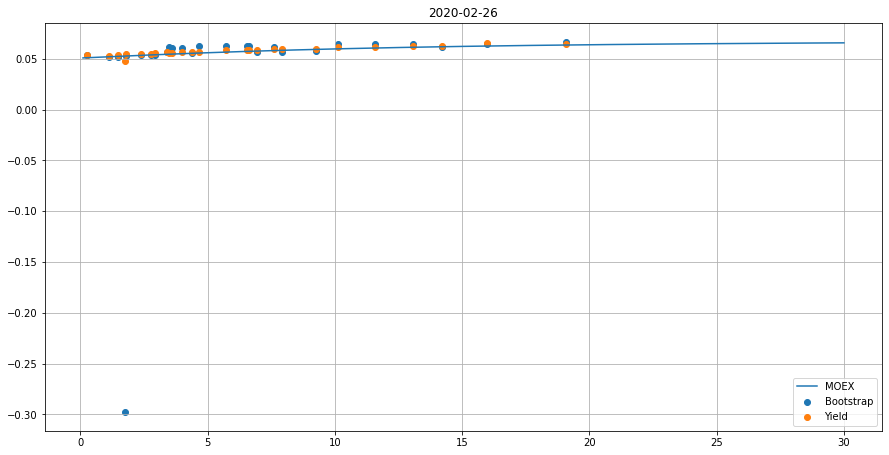

In [160]:
j = 1542

m = np.linspace(0.1, 30, 300)

plt.figure(figsize = (15, 7.5))
plt.title(dates[j].date())
plt.scatter(bootstraped_rates_list[j].maturity, bootstraped_rates_list[j].rates, label = 'Bootstrap')
plt.scatter(maturity_matrix[dates[j]:dates[j]].values, irr_matrix[dates[j]:dates[j]].values, label = 'Yield')
plt.plot(m, ns(m, moex_thetas[dates[j]:dates[j]].values[0]), label = 'MOEX')
plt.legend(loc = 4)
#plt.ylim(0, 0.2)
plt.grid();

# Now we need to clean these yields in some way

We will delete all those yields which are 1 standarad deviaiton away from the mean of day yield.

In [110]:
dates[107], dates[150], dates[285], dates[314], dates[331], dates[1542]

(Timestamp('2014-06-17 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2015-03-02 00:00:00'),
 Timestamp('2015-04-13 00:00:00'),
 Timestamp('2015-05-08 00:00:00'),
 Timestamp('2020-02-26 00:00:00'))

In [6]:
filtered_bootstraped_rates = []
std_factor = 3

for i in range(len(dates)):
    mean_yield = bootstraped_rates_list[i].rates.median()
    yield_std = bootstraped_rates_list[i].rates.std()
    
    mask = (bootstraped_rates_list[i].rates < mean_yield + std_factor * yield_std) & \
           (bootstraped_rates_list[i].rates > mean_yield - std_factor * yield_std)
        
    filtered_bootstraped_rates.append(bootstraped_rates_list[i][mask])
    
#    if bootstraped_rates_list[i][~mask].empty == False:
#        print(i, dates[i])
#        print(bootstraped_rates_list[i][~mask])

In [24]:
for i in range(len(dates)):
    filtered_bootstraped_rates[i].to_csv(path + 'Data/New_data/Filtered_bootstraped_rates/bt_rates_' + \
                                         str(dates[i].date()) + '.csv')

In [12]:
filtered_bootstraped_rates = []

for i in range(len(dates)):
    filtered_bootstraped_rates.append(pd.read_csv(path + 'Data/New_data/Filtered_bootstraped_rates/bt_rates_' + \
                                                  str(dates[i].date()) + '.csv', index_col=0))

# Are the yields ok?

In [9]:
yield_moex_curve_MAE = np.zeros(len(dates))

for i in range(len(dates)):
    concat_df = pd.concat([maturity_matrix[dates[i]:dates[i]].dropna(axis = 1), irr_matrix[dates[i]:dates[i]].dropna(axis = 1)])
    sorted_df = concat_df.T
    sorted_df.columns = ['Maturity', 'Yield']
    yields = sorted_df.sort_values(['Maturity']).Yield.values
    moex_yields = ns(sorted_df.Maturity, moex_thetas[dates[i]:dates[i]].values[0])
    yield_moex_curve_MAE[i] = np.mean(np.abs(moex_yields - yields))

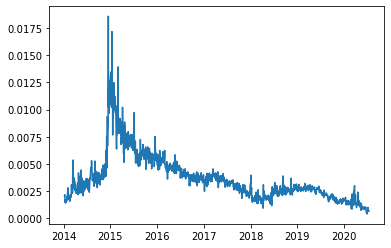

In [10]:
plt.plot(dates, yield_moex_curve_MAE)

In [11]:
bootstrap_moex_curve_MAE = np.zeros(len(dates))

for i in range(len(dates)):
    moex_yields = ns(bootstraped_rates_list[i].maturity.values, moex_thetas[dates[i]:dates[i]].values[0])
    bootstrap_moex_curve_MAE[i] = np.mean(np.abs(moex_yields - bootstraped_rates_list[i].rates.values))

In [12]:
filtered_bootstrap_moex_curve_MAE = np.zeros(len(dates))

for i in range(len(dates)):
    moex_yields = ns(filtered_bootstraped_rates[i].maturity.values, moex_thetas[dates[i]:dates[i]].values[0])
    filtered_bootstrap_moex_curve_MAE[i] = np.mean(np.abs(moex_yields - filtered_bootstraped_rates[i].rates.values))

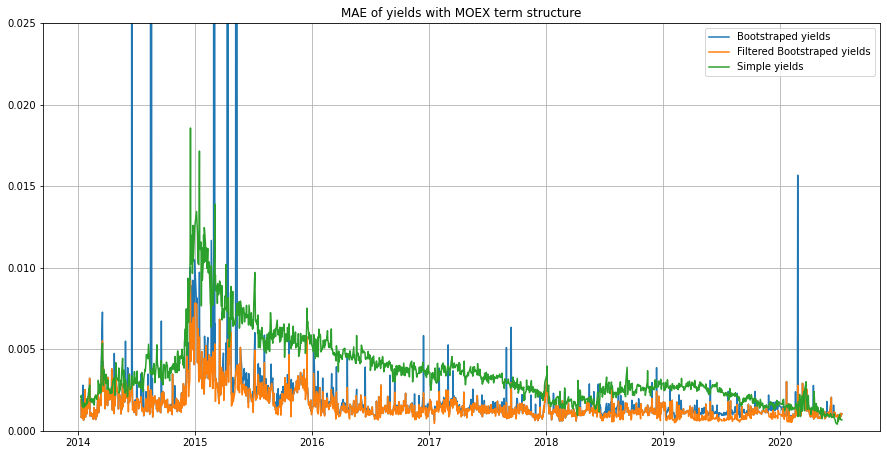

In [13]:
plt.figure(figsize = (15, 7.5))
plt.title('MAE of yields with MOEX term structure')
plt.plot(dates, bootstrap_moex_curve_MAE, label = 'Bootstraped yields')
plt.plot(dates, filtered_bootstrap_moex_curve_MAE, label = 'Filtered Bootstraped yields')
plt.plot(dates, yield_moex_curve_MAE, label = 'Simple yields')
plt.legend()
plt.ylim(0, 0.025)
plt.grid(True)

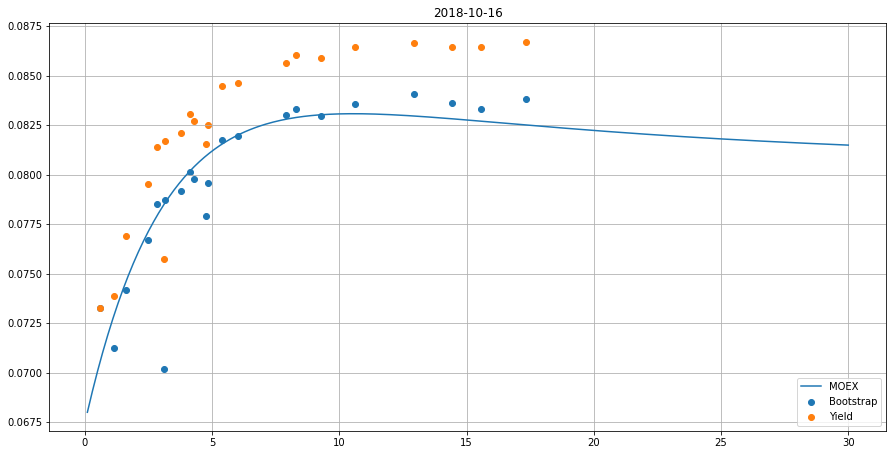

In [102]:
j = 1200

m = np.linspace(0.1, 30, 300)

plt.figure(figsize = (15, 7.5))
plt.title(dates[j].date())
plt.scatter(filtered_bootstraped_rates[j].maturity, filtered_bootstraped_rates[j].rates, label = 'Bootstrap')
plt.scatter(maturity_matrix[dates[j]:dates[j]].values, irr_matrix[dates[j]:dates[j]].values, label = 'Yield')
plt.plot(m, ns(m, moex_thetas[dates[j]:dates[j]].values[0]), label = 'MOEX')
plt.legend(loc = 4)
#plt.ylim(0, 0.2)
plt.grid();

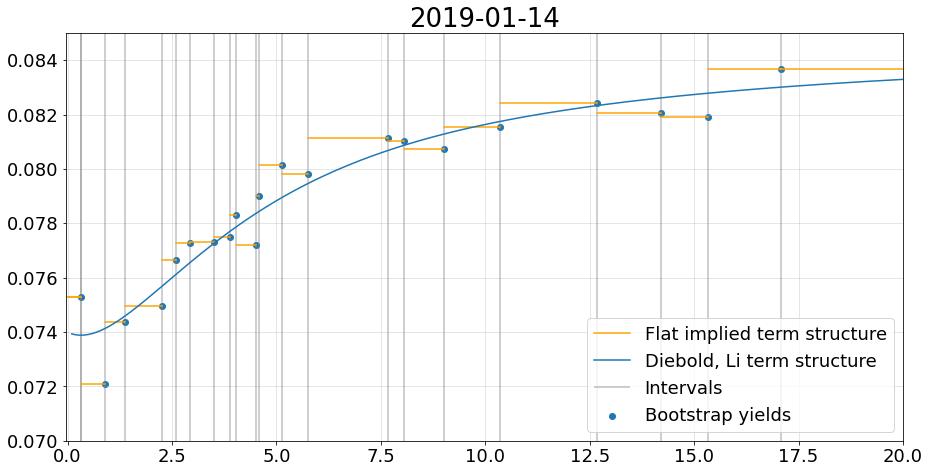

In [151]:
j = 1260

m = np.linspace(0.1, 30, 300)

plt.figure(figsize = (15, 7.5))
plt.title(dates[j].date(), fontsize = 26)

for i in range(filtered_bootstraped_rates[j].shape[0] + 1):
    if i == 0:
        plot_data = np.zeros([2, 2])
        plot_data[1, :] = filtered_bootstraped_rates[j].iloc[i].values
        plot_data[0, 1] = plot_data[1, 1]
        plt.plot(plot_data[:,0], plot_data[:,1], color = 'orange', label = 'Flat implied term structure')
        plt.vlines(plot_data[1, 0], ymin = 0.07, ymax = 0.085, color = 'grey', alpha = 0.5, label = 'Intervals')
    elif i == filtered_bootstraped_rates[j].shape[0]:
        plot_data = np.zeros([2, 2])
        plot_data[0, :] = filtered_bootstraped_rates[j].iloc[i-1].values
        plot_data[1, 1] = plot_data[0, 1]
        plot_data[1, 0] = 30
    else:
        plot_data = np.zeros([2, 2])
        plot_data[1, :] = filtered_bootstraped_rates[j].iloc[i].values
        plot_data[0, 0] = filtered_bootstraped_rates[j].iloc[i-1].values[0]
        plot_data[0, 1] = plot_data[1, 1]
    plt.plot(plot_data[:,0], plot_data[:,1], color = 'orange')
    plt.vlines(plot_data[1, 0], ymin = 0.07, ymax = 0.085, color = 'grey', alpha = 0.5)

plt.scatter(filtered_bootstraped_rates[j].maturity, filtered_bootstraped_rates[j].rates, label = 'Bootstrap yields')
plt.plot(m, ns(m, diebold_li_weights.iloc[j].values), label = 'Diebold, Li term structure')

plt.ylim([0.07, 0.085])
plt.xlim([-0.04, 20])
plt.grid(alpha = 0.4)
plt.tick_params(axis='x', which='major', labelsize=18)
plt.tick_params(axis='y', which='major', labelsize=18)
plt.legend(fontsize = 18,  loc = 4)
plt.savefig('Pictures/Fama_Bliss_yields.png');

If not for the spikes, the bootstrap yields are closer to the term structure provided by MOEX.

Filtered work great!!!

## Diebold-Li weights generation

In [145]:
import statsmodels.api as sm

In [146]:
def get_loadings(m, tau):
    
    level = np.ones(m.shape[0])
    slope_hump = (1 - np.exp(- m / tau)) / (m / tau)
    hump =  - np.exp(- m / tau) 

    return level, slope_hump, hump

We set $\tau$ according to Diebold, Li 2006. The screnshot in the folder shows the way we obtained it.

In [147]:
def get_diebold_li_weights(day_number):

    df_shape = filtered_bootstraped_rates[day_number].shape[0]

    X = np.zeros([df_shape, 3])
    X[:,0], X[:,1], X[:,2] = get_loadings(m = filtered_bootstraped_rates[day_number].maturity.values, tau = 1.4)
       
    y = filtered_bootstraped_rates[day_number].rates.values

    model = sm.OLS(y, X)
    beta = model.fit().params
    
    ns_theta = np.zeros(4)
    ns_theta[0] = 1.4
    ns_theta[1] = beta[0]
    ns_theta[2] = beta[1] - beta[2]
    ns_theta[3] = beta[2]

    return ns_theta

In [148]:
%%time

diebold_li_weights = pd.DataFrame(np.zeros([bonds_prices.shape[0], 4]), index = dates,
                                  columns = ['tau', 'beta0', 'beta1', 'beta2'])

for i in range(diebold_li_weights.shape[0]):
    diebold_li_weights.iloc[i] = get_diebold_li_weights(i)
    
diebold_li_weights.to_csv(path + 'Data/New_data/diebold_li.csv')

CPU times: user 871 ms, sys: 20 ms, total: 891 ms
Wall time: 959 ms


In [149]:
diebold_li_weights = pd.read_csv(path + 'Data/New_data/diebold_li.csv', index_col = 0)

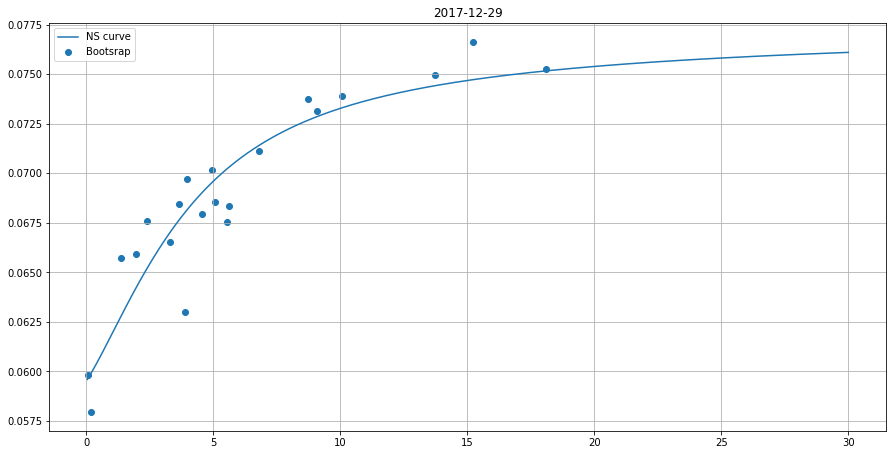

In [150]:
j = 1000

m = np.linspace(0, 30, 600)
plt.figure(figsize = (15,7.5))
plt.grid()
plt.plot(m, ns(m, diebold_li_weights.iloc[j].values), label = 'NS curve')
plt.title(dates[j].date())
plt.scatter(filtered_bootstraped_rates[j].maturity, filtered_bootstraped_rates[j].rates, label = 'Bootsrap')
plt.legend();

# Diebold, Li values based on interpretation 

### Calculating yields

In [185]:
yields = pd.DataFrame(np.zeros([bonds_prices.shape[0], 4]), index = dates,
                      columns = ['3-month', '2-year', '10-year', 'longest'])

for i in range(len(dates)):
    sorted_bonds = maturity_matrix.iloc[i].sort_values()
    sorted_bonds.dropna(inplace=True)
    
    month_3_bond = sorted_bonds.iloc[(sorted_bonds-1/4).abs().argsort()].index[0]
    year_2_bond = sorted_bonds.iloc[(sorted_bonds-2).abs().argsort()].index[0]
    year_10_bond = sorted_bonds.iloc[(sorted_bonds-10).abs().argsort()].index[0]
    longest_bond = sorted_bonds.index[-1]
    
    yields.at[dates[i], '3-month'] = irr_matrix[dates[i]:dates[i]][month_3_bond]
    yields.at[dates[i], '2-year'] = irr_matrix[dates[i]:dates[i]][year_2_bond]
    yields.at[dates[i], '10-year'] = irr_matrix[dates[i]:dates[i]][year_10_bond]
    yields.at[dates[i], 'longest'] = irr_matrix[dates[i]:dates[i]][longest_bond]              

In [186]:
yields.to_csv(path + 'Data/New_data/yields.csv')

In [187]:
i = 1

tau = 0.717313
beta_0 = yields[dates[i]:dates[i]]['longest'][0]
beta_1 = yields[dates[i]:dates[i]]['10-year'][0] - yields[dates[i]:dates[i]]['3-month'][0]
beta_2 = 2 * yields[dates[i]:dates[i]]['2-year'][0] - yields[dates[i]:dates[i]]['3-month'][0] - yields[dates[i]:dates[i]]['10-year'][0]

[ 0.717313    0.08086156  0.01810876 -0.00996742]


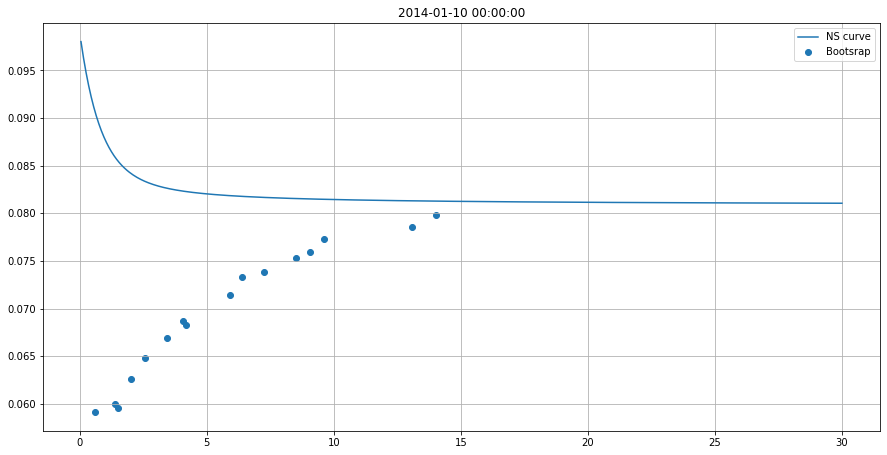

In [188]:
i = 1

tau = 0.717313
beta_0 = yields[dates[i]:dates[i]]['longest'][0]
beta_1 = yields[dates[i]:dates[i]]['10-year'][0] - yields[dates[i]:dates[i]]['3-month'][0]
beta_2 = 2 * yields[dates[i]:dates[i]]['2-year'][0] - yields[dates[i]:dates[i]]['3-month'][0] - yields[dates[i]:dates[i]]['10-year'][0]

theta = np.array([tau, beta_0, beta_1, beta_2])

m = np.linspace(0, 30, 600)
plt.figure(figsize = (15,7.5))
plt.title(dates[i])
plt.grid()
plt.plot(m, ns(m, theta), label = 'NS curve')
plt.scatter(bootstraped_rates_list[i].maturity, bootstraped_rates_list[i].rates, label = 'Bootsrap')
plt.legend()
print(theta);

It looks bad, even though I've done excatly as Diebold, Li interprets the parameters. So, yet I wouldn't use them.

# Manousopoulos values

In [437]:
%%time

manousopoulos_values = pd.DataFrame(np.zeros([bonds_prices.shape[0], 4]), index = dates, 
                                  columns = ['tau', 'beta_0', 'beta_1', 'beta_2'])

manousopoulos_values['tau'] = np.ones(bonds_prices.shape[0])

for i in range(len(dates)):
    sorted_bonds = maturity_matrix.iloc[i].sort_values()
    sorted_bonds.dropna(inplace=True)
    
    shortest_bond = sorted_bonds.index[0]
    longest_bonds = sorted_bonds.index[-4:]
    
    manousopoulos_values.at[dates[i], 'beta_0'] = irr_matrix[dates[i]:dates[i]][longest_bonds].mean(axis = 1)[0]
    manousopoulos_values.at[dates[i], 'beta_1'] = irr_matrix[dates[i]:dates[i]][shortest_bond][0] - manousopoulos_values[dates[i]:dates[i]]['beta_0'][0]

CPU times: user 2.73 s, sys: 12.9 ms, total: 2.74 s
Wall time: 2.77 s


In [438]:
manousopoulos_values.to_csv(path + 'Data/New_data/manousopoulos.csv')

In [417]:
manousopoulos_values = pd.read_csv(path + 'Data/New_data/manousopoulos.csv', index_col = 0)

In [ ]:
plt.figure(figsize = (20, 10))
plt.title('Maturities of Bonds', fontsize = 40)
plt.xlabel('Date', fontsize = 26)
plt.ylabel('Time to maturity (years)', fontsize = 26)
plt.tick_params(axis='x', which='major', labelsize=26, labelrotation = 30)
plt.tick_params(axis='y', which='major', labelsize=26)
plt.xlim([dates[0] - dt.timedelta(days = 8), dates[-1]])
plt.ylim([0, 23])
plt.grid(True)

for ISIN in ISINs: 
    plt.plot(term_to_maturity_df[ISIN], linewidth=4, color = 'b')
    
plt.savefig('Pictures/Bonds.png');

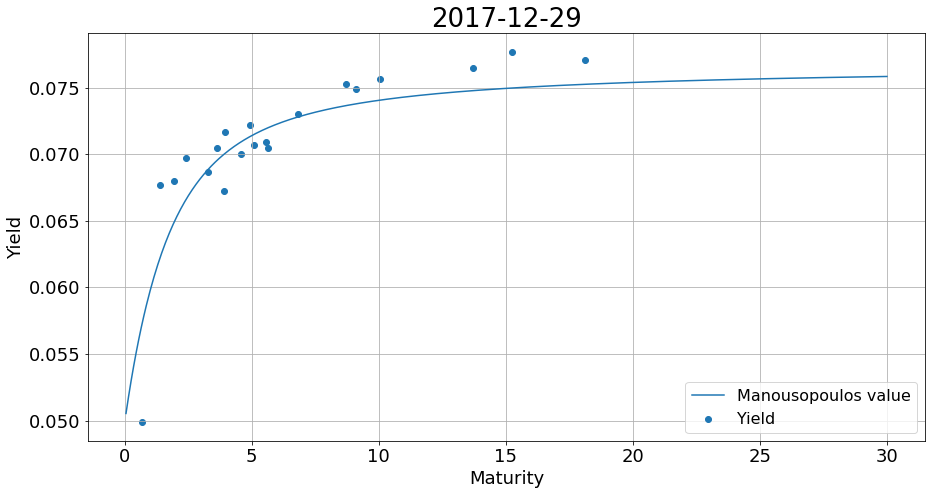

In [467]:
i = 1000

m = np.linspace(0, 30, 600)
plt.figure(figsize = (15,7.5))
plt.title(dates[i].date(), fontsize = 26)
plt.xlabel('Maturity', fontsize = 18)
plt.ylabel('Yield', fontsize = 18)
plt.tick_params(axis='x', which='major', labelsize=18)
plt.tick_params(axis='y', which='major', labelsize=18)
plt.grid(True)
plt.plot(m, ns(m, manousopoulos_values.iloc[i]), label = 'Manousopoulos value')
#plt.scatter(bootstraped_rates_list[i].maturity, bootstraped_rates_list[i].rates, label = 'Bootsrap')
plt.scatter(maturity_matrix[dates[i]:dates[i]], irr_matrix[dates[i]:dates[i]], label = 'Yield')
plt.legend(loc = 4, fontsize = 16)
plt.savefig('Pictures/Manousopoulos_value.png');

Looks much better